## Utilisation du jeu de données Xview2, qui intitialement présebnte des exemples de territoire avant et après dommage

Je m'écarte ici un peu de l'idée initiale qui était de produire un dataset à l'aide du RIl et de la BDTOPO et je me concentre + sur les datasets labellisés préexistants. J'entraine un modèle de segmentation de suus ou un modèle de déttection d'objet et je vois comment ça réagit sur donnée spleiades. 
Dans tousd les cas le travail sur le RIL et la BD TOPO est à conserver puisque ces derniers servent de vzlidation !

In [1]:
from zipfile import ZipFile
import s3fs
import tarfile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import torchvision
from torch.utils.data import DataLoader,  random_split
from torch.utils.data.dataset import Dataset

fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},key ='HPC7PNZMF3SC28Q5FYY3', secret = '3DfluFzC0ZqQlCk2ifJLNy4Xra0D4tbwzoraa2ET', token = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJIUEM3UE5aTUYzU0MyOFE1RllZMyIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNjc1MzM4MzkyLCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6ImNsZW1lbnQuZ3VpbGxvQGluc2VlLmZyIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImV4cCI6MTY3NTQ0ODc5MSwiZmFtaWx5X25hbWUiOiJHdWlsbG8iLCJnaXZlbl9uYW1lIjoiQ2zDqW1lbnQiLCJncm91cHMiOlsiY2hhbGxlbmdlZGF0YS1lbnMiLCJmdW5hdGhvbiIsInNsdW1zLWRldGVjdGlvbiJdLCJpYXQiOjE2NzUzMzk2NTIsImlzcyI6Imh0dHBzOi8vYXV0aC5sYWIuc3NwY2xvdWQuZnIvYXV0aC9yZWFsbXMvc3NwY2xvdWQiLCJqdGkiOiI2NWVhMDA1Zi1hOTg0LTQ1ODctYWRhMS01ZWI5MTI4Mzg5NDMiLCJsb2NhbGUiOiJlbiIsIm5hbWUiOiJDbMOpbWVudCBHdWlsbG8iLCJub25jZSI6ImUwNDY0Zjc3LTU0OTctNGVmMi04NGRkLTI1OTdhNGIwNzI5OSIsInBvbGljeSI6InN0c29ubHkiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJjZ3VpbGxvIiwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGdyb3VwcyBlbWFpbCIsInNlc3Npb25Qb2xpY3kiOiJleUpXWlhKemFXOXVJam9pTWpBeE1pMHhNQzB4TnlJc0lsTjBZWFJsYldWdWRDSTZXM3NpUldabVpXTjBJam9pUVd4c2IzY2lMQ0pCWTNScGIyNGlPbHNpY3pNNktpSmRMQ0pTWlhOdmRYSmpaU0k2V3lKaGNtNDZZWGR6T25Nek9qbzZjSEp2YW1WMExYTnNkVzF6TFdSbGRHVmpkR2x2YmlJc0ltRnlianBoZDNNNmN6TTZPanB3Y205cVpYUXRjMngxYlhNdFpHVjBaV04wYVc5dUx5b2lYWDBzZXlKRlptWmxZM1FpT2lKQmJHeHZkeUlzSWtGamRHbHZiaUk2V3lKek16cE1hWE4wUW5WamEyVjBJbDBzSWxKbGMyOTFjbU5sSWpwYkltRnlianBoZDNNNmN6TTZPam9xSWwwc0lrTnZibVJwZEdsdmJpSTZleUpUZEhKcGJtZE1hV3RsSWpwN0luTXpPbkJ5WldacGVDSTZJbVJwWm1aMWMybHZiaThxSW4xOWZTeDdJa1ZtWm1WamRDSTZJa0ZzYkc5M0lpd2lRV04wYVc5dUlqcGJJbk16T2tkbGRFOWlhbVZqZENKZExDSlNaWE52ZFhKalpTSTZXeUpoY200NllYZHpPbk16T2pvNktpOWthV1ptZFhOcGIyNHZLaUpkZlYxOSIsInNlc3Npb25fc3RhdGUiOiI3YzFjMWIzNi0xNDM4LTQ2OWItOWYwNi1lOGY1ODFkMWM4MzkiLCJzaWQiOiI3YzFjMWIzNi0xNDM4LTQ2OWItOWYwNi1lOGY1ODFkMWM4MzkiLCJzdWIiOiIzYjA2ZWZhNC01OWZlLTQzYzgtYTAyYi1hOTRkOWI0YjU0NGUiLCJ0eXAiOiJCZWFyZXIifQ.ob4PwOHQerwgrx_es8u_nIHph-Iqt_1RLz4CvR_Bn8D67q8XJoGsHULDKvV19i6dB9TPZA-qi2oYIzVGOD3SJA')

In [3]:
# je travaille sur une version minimale du dataset xview, le vrai fait 50 giga.. mais ça devrait déjà faire l'affaire pour travailler
fs.get('projet-slums-detection/Donnees/data_xBD.tar', 'data_xBD.tar')

In [4]:
tar = tarfile.open("data_xBD.tar", "r:gz")
tar.extractall()
tar.close()

### chargement/observation en place des données

In [2]:
liste_image  = sorted(os.listdir("train/images/"))
liste_label  = sorted(os.listdir("train/labels/")) # boundingbox et polygones !!
liste_target  = sorted(os.listdir("train/targets/")) # le masque de segmentation !!

In [42]:
label_path = 'train/labels/hurricane-florence_00000024_pre_disaster.json'

In [3]:
selec_pre_disaster = [nom_image.split("_")[2] == "pre" for nom_image in liste_image]
liste_image = np.array(liste_image)[selec_pre_disaster]
liste_label = np.array(liste_label)[selec_pre_disaster]
liste_target = np.array(liste_target)[selec_pre_disaster]

print(np.sum(selec_pre_disaster)) # 3000 images pour s'entrainer avec des exemples entourés


2799


## Observation du dataset

- Images de dimension 1024-1024 à découper en 4 * 250 pour avoir un diviseur de 2000 (pour les données pleiades) (donc en 4)
- Dans la classe data set splitter l'image en 4 et prendre un bout aléatoirement à chaque fois
- image à 3 channels, pas de RGB ici..
- est ce vraiment la mêlme résolution que pleiade ? résistance à la résolution ?

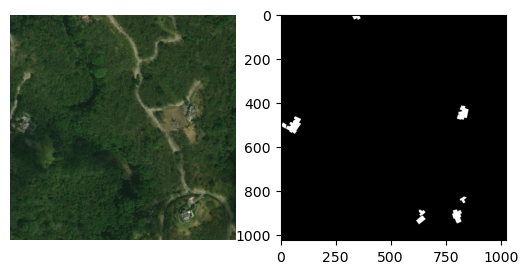

In [4]:
img = Image.open("train/images/guatemala-volcano_00000007_pre_disaster.png")
img = img.resize((1000,1000))

masque = Image.open("train/targets/guatemala-volcano_00000007_pre_disaster_target.png")
masque = np.array(masque)
show_mask = np.empty((*masque.shape, 3))
show_mask[masque == 1, :] = [255,255,255]
show_mask = show_mask.astype(np.uint8)

# On traçe
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(img)
ax1.axis("off")
ax2.imshow(show_mask)
plt.show()

A mettre dans la classe dataset ! sélection d'un pa(tch aléatoire parmi les 16  possibles

3 0


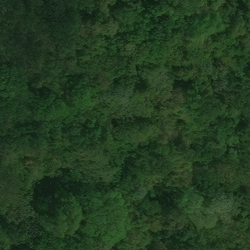

In [6]:
img = Image.open("train/images/guatemala-volcano_00000007_pre_disaster.png")

img = img.crop((0,0,1000,1000))# je dégomme les derniers pixels..
img

facteur_div = 250
width, height = img.size

num_subparts_x = width//facteur_div
num_subparts_y =  height//facteur_div

# sélection aléatoire d'une aprtie de l'image pour le dataset
i = np.random.randint(num_subparts_x)
j = np.random.randint(num_subparts_y)

print(i,j)

left = j * facteur_div
right = (j+1) * facteur_div
top = i * facteur_div
bottom =(i+1)*facteur_div

out = img.crop((left,top,right,bottom))
out

Polygones associés au bati

In [133]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 1.1 MB/s eta 0:00:0000:01m00:05
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 7.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 7.2 MB/s eta 0:00:00a 0:00:01


In [31]:
 class CustomDataset(Dataset):
    def __init__(self, image_paths,mask_paths, facteur_div = 250):   # initial logic happens like transform
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.facteur_div = 250
        
    def __getitem__(self, idx):
       
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        with Image.open(self.image_paths[idx]) as img :
            
            width, height = img.size

            num_subparts_x = width//facteur_div
            num_subparts_y =  height//facteur_div
            # sélection aléatoire d'une aprtie de l'image pour le dataset
            i = np.random.randint(num_subparts_x)
            j = np.random.randint(num_subparts_y)

            left = j * facteur_div
            right = (j+1) * facteur_div
            top = i * facteur_div
            bottom =(i+1)*facteur_div

            img = img.crop((left,top,right,bottom))
            img = img.convert("RGB")
            img_pil = img
            
        with Image.open(self.mask_paths[idx]) as masque :
            masque = masque.crop((left,top,right,bottom))
            masque = np.array(masque)
         
        
        masque = torch.tensor(masque,dtype = torch.long)
        img = torch.tensor(np.array(img,dtype = float), dtype =torch.float).permute(2,0,1)
        
        ID = str(self.image_paths[idx])
     
        return {"image": img, "masque" : masque,"image_pillow": np.array(img_pil) , "id" : ID} 
        
    def __len__(self):  
        return len(self.mask_paths)

In [33]:
train_images_paths = ["train/images/" + elt for elt in liste_image]
train_masks_paths = ["train/targets/" + elt for elt in liste_target]

all_dataset = CustomDataset(train_images_paths,train_masks_paths)
one_element = next(iter(all_dataset))

one_element["image"].shape
#torch.max(one_element["masque"])


torch.Size([3, 250, 250])

In [34]:
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=True, num_workers=0)

train_size = 2000
val_size = len(all_dataset.mask_paths) - train_size
#dans la liste donner la taille du train et la taille deu test
train_dataset, valid_dataset = random_split(all_dataset,[train_size,val_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=32, 
                          shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=0)

next(iter(valid_loader))["image"].shape # parfait

torch.Size([32, 3, 250, 250])

In [12]:
# Load the pretrained model
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True) # 233 Mega

/opt/mamba/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Avant le training 

In [42]:
loss_fn = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print("load batch")
data = next(iter(train_loader)) 
images = data["image"]
labels = data["masque"]
optimizer.zero_grad()
print("apply model")
outputs = model(images)['out']


load batch
apply model


In [25]:
output_predictions.shape

torch.Size([250, 250])

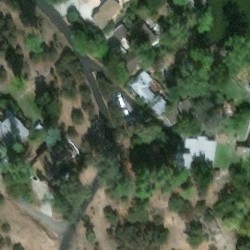

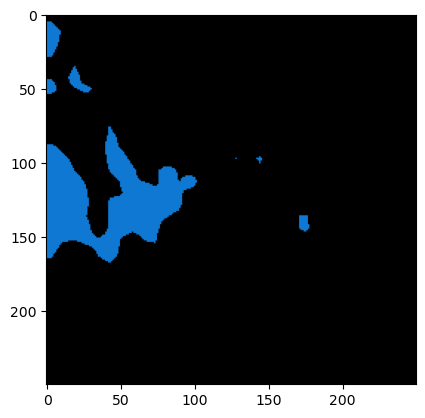

In [48]:
indice_dans_batch = 20
output_predictions = outputs.argmax(1)[indice_dans_batch]
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy())
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)

Image.fromarray(np.array(data["image_pillow"][indice_dans_batch]))


LE pretrain ne peut être utilisé comme ça sur des images satellites d'où la nécessité de l'entrainer

#### Training

In [193]:
# autre idée : pour un batch donné 
loss_fn = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
loss = 0
for epoch in range(100):
    for i, data in enumerate(train_loader):
        print(loss)
        images = data["image"]
        labels = data["masque"]
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
# Save the trained model
#torch.save(model.state_dict(), 'path/to/model.pth')


0


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not collections.OrderedDict

In [ ]:
t= tqdm(train_loader, desc="epoch %i" % (epoch+1),position = 0, leave=True)
epoch_loop = enumerate(t)

for i, data in epoch_loop:

    taille_batch = data['image'].shape[0]
    images = data['image'].permute(0,3,1,2)
    masques  =  data['masque']


    images, masques = images.to(device), masques.long().to(device)

    y_hat = net(images)

    optimizer.zero_grad()
    loss = entropy(y_hat,masques)

    loss.backward()
    optimizer.step()

    del images, masques, y_hat # libéreer un peu d'espace

    running_loss += loss.item()
    if (i+1) % config['freq monitoring'] == 0:  
        t.set_description("epoch %i, 'mean loss: %.6f'" % (epoch+1,running_loss/config['freq monitoring']))
        t.refresh()
        running_loss =0

### Les contours géométriques en Json si besoin !! bounding box etc..

In [ ]:
import json
f = open(label_path)
dico = jason.load(f)
  
# Closing file
f.close()

In [21]:
dico.keys()
dico["metadata"]

{'sensor': 'GEOEYE01',
 'provider_asset_type': 'GEOEYE01',
 'gsd': 1.958603,
 'capture_date': '2018-04-06T15:49:36.000Z',
 'off_nadir_angle': 24.974987,
 'pan_resolution': 0.4894778,
 'sun_azimuth': 140.36385,
 'sun_elevation': 55.891373,
 'target_azimuth': 282.33646,
 'disaster': 'hurricane-florence',
 'disaster_type': 'flooding',
 'catalog_id': '105001000F48CD00',
 'original_width': 1024,
 'original_height': 1024,
 'width': 1024,
 'height': 1024,
 'id': 'MjM1NDMxMg.nXO3IBd7BnYBtW8COFwnVkMrXUQ',
 'img_name': 'hurricane-florence_00000024_pre_disaster.png'}